# Simple Case Impacts on Linear Regression Fit and Prediction

In [1]:
%autoreload 2

from generator import *
from shredder import *
from fitter import *
from fixer import *
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
np.random.seed(10)

ERROR:root:Line magic function `%autoreload` not found.
/Users/eilifm/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Generating regression data -- Background
`x_def_helper` helps define a single random variables as required.  It accepts the name of the desired distribution, the coefficient value, and the keyword arguments that define the distribution according to the Numpy random generators.

`generate_ind_model` creates a `p` regressor linear regression set as specified in the `dist_types` argument, a list of `dicts` generated by `x_def_helper`. The user must also specify the intercept, noise_factor, and number of observations.  This will return a tuple of two dataframes, one is (`n`, `p`), the other, a test set, is (`.5*n`, `p`).


## Case 1: Single Uniformly Distributed Regressor -- Generate the data

In [2]:
# Declare that there should be one X uniformly distributed between 0 and 100 with a coefficient of 5.

dist_types = [
#     x_def_helper('lognormal', coeff=10, mean=0, sigma=1),
    x_def_helper('uniform', coeff=6, low=0, high=100)
]

x1_uniform_clean_fit_data, x1_uniform_test_data, x1_uniform_coeffs = generate_ind_model(1, dist_types, intercept=10, n=200, noise_factor=.1)

print("The shape of the data set and the test set")
print(x1_uniform_clean_fit_data.shape, x1_uniform_test_data.shape)

The shape of the data set and the test set
(200, 2) (100, 2)


In [3]:
x1_uniform_clean_fit_data.head()

,x1,y
0,77.132064,416.440410
1,2.075195,57.203265
2,63.364823,394.254979
3,74.880388,542.732679
4,49.850701,268.550153


### Initial EDA/Modeling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112bcac88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112ccbb70>]], dtype=object)

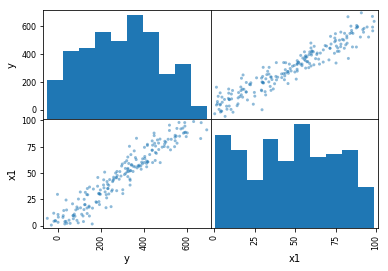

In [4]:
scatter_matrix(x1_uniform_clean_fit_data[['y', 'x1']])

### Building and checking a model fit to the unaltered data

In [5]:
ex_fitted, ex_metrics, = fit_lm(x1_uniform_clean_fit_data, x1_uniform_test_data)
print(ex_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1893.
Date:                Thu, 08 Feb 2018   Prob (F-statistic):          2.73e-103
Time:                        08:16:54   Log-Likelihood:                -1081.7
No. Observations:                 200   AIC:                             2167.
Df Residuals:                     198   BIC:                             2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7035      7.634      1.140      0.2

In [6]:
beta_target_check(ex_metrics, x1_uniform_coeffs)

,in_ci
var,
x1,1
const,1


Text(0.5,15,'x1')

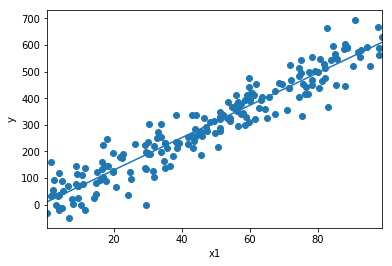

In [7]:
fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(x1_uniform_clean_fit_data['x1'], x1_uniform_clean_fit_data['y'])
plt.ylabel('y')
plt.xlabel('x1')

47.205441448840865


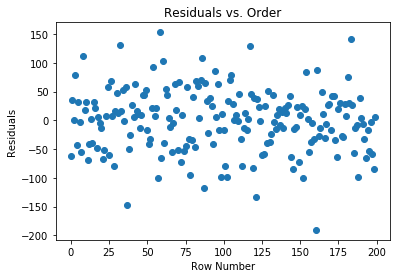

In [8]:
plt.plot(ex_fitted.resid, marker='o', linestyle='')
plt.title('Residuals vs. Order')
plt.ylabel('Residuals')
plt.xlabel('Row Number')

# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.influence_plot(ex_fitted, ax=ax, criterion="cooks")
print(x1_uniform_clean_fit_data['x1'].mean())

34.6153688116


2630.9909479986322

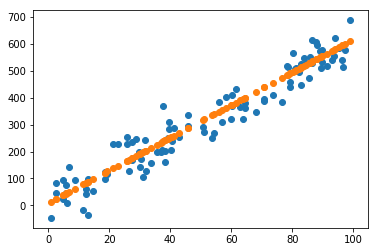

In [9]:
test_X = x1_uniform_test_data.loc[:, x1_uniform_test_data.columns != "y"]
test_X = sm.add_constant(test_X)
test_y = x1_uniform_test_data.loc[:, 'y']
y_pred = ex_fitted.predict(test_X)


fig, ax = plt.subplots()
ax.scatter(test_X['x1'], test_y)
ax.scatter(test_X['x1'], y_pred)

print(mean_absolute_percentage_error(test_y, y_pred))
mean_squared_error(test_y, y_pred)

In [28]:
wreck_results = []
# Begin replication loop
for i in range(50):
    
    # Begin percent range loop
    for pct in np.arange(0, 1, .025):
    
        # Make a copy of the dataset so that we do not contaminate the memory
        wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)

        # Shred the data unless pct == 0
        if pct != 0:
            # Specify that we are shredding x1
            uniform_shred_cols(['x1'], pct, wrecked_data)
            wrecked_data = wrecked_data.dropna()

        w_fitted, w_metrics, = fit_lm(wrecked_data, x1_uniform_test_data)

        b_estimate_results = beta_target_check(w_metrics, x1_uniform_coeffs)
       
        wreck_results.append((pct,
                              w_fitted.nobs,
                              w_metrics['r2'],
                              w_metrics['r2_adj'],
                              w_metrics['bic'],
                              w_metrics['beta_ci']['x1']['range'],
                              b_estimate_results.loc['x1', :].values[0],
                              w_metrics['r2_pred'],
                              w_metrics['mse_pred']))


# Load the results into a Pandas Dataframe
results_df = pd.DataFrame(wreck_results, columns=['pct_missing', 
                                                  'nobs', 
                                                  'r2', 
                                                  'r2_adj',
                                                  'bic', 
                                                  'beta_x1_rng',
                                                  'beta_x1_target',
                                                  'r2_pred', 
                                                  'mse'])

In [20]:
# Processing results
x1_uniform_results = results_df.groupby('pct_missing').mean()
x1_uniform_results

,nobs,r2,r2_adj,bic,beta_x1_rng,beta_x1_target,r2_pred,mse
pct_missing,,,,,,,,
0.000,200.0,0.905292,0.904814,2173.969420,0.551250,1.0,0.923170,2630.990948
0.025,195.0,0.904698,0.904204,2119.301813,0.560499,1.0,0.923087,2633.828890
0.050,190.0,0.904637,0.904130,2063.660000,0.566543,1.0,0.923099,2633.412606
0.075,185.0,0.903444,0.902917,2011.432752,0.578385,1.0,0.923282,2627.129085
0.100,180.0,0.903679,0.903138,1959.157966,0.588613,1.0,0.922987,2637.256893
0.125,175.0,0.908408,0.907878,1898.288698,0.580142,1.0,0.923101,2633.336798
0.150,170.0,0.907783,0.907234,1843.581300,0.590695,1.0,0.923177,2630.734960
0.175,165.0,0.902868,0.902272,1799.540276,0.616999,1.0,0.922570,2651.535186
0.200,160.0,0.909290,0.908716,1733.289478,0.599260,1.0,0.922185,2664.696756


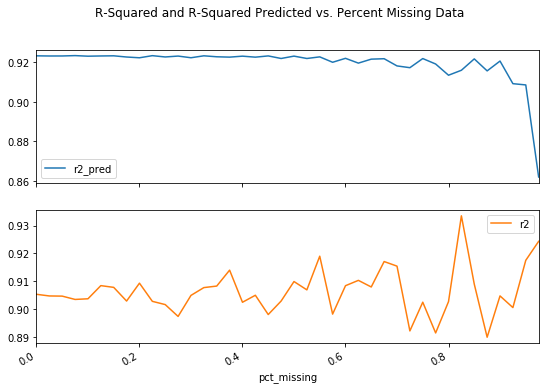

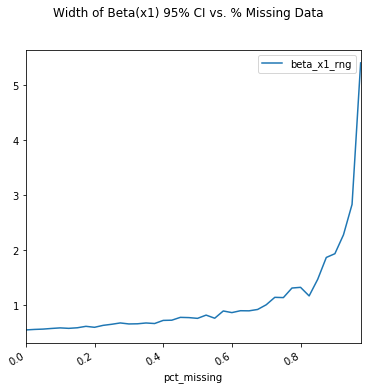

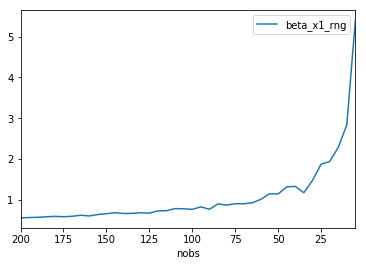

In [21]:
x1_uniform_results[['r2_pred', 'r2']].plot(subplots=True, figsize=(9, 6), title='R-Squared and R-Squared Predicted vs. Percent Missing Data')
print()

x1_uniform_results[['beta_x1_rng']].plot(subplots=True, figsize=(6, 6), title='Width of Beta(x1) 95% CI vs. % Missing Data')

x1_uniform_results.plot(y='beta_x1_rng', x='nobs')
#init_results[['beta_x1_low', 'beta_x1_high']].plot(figsize=(9, 9))
                                       
#init_results['log_beta_x1_rng'] = np.log(init_results[['beta_x1_rng']])
#init_results[['log_beta_x1_rng']].plot(subplots=True, figsize=(9, 9))

In [22]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .4, wrecked_data)

wrecked_data.head(n=10)

,x1,y
0,NaN,416.440410
1,NaN,57.203265
2,63.364823,394.254979
3,74.880388,542.732679
4,49.850701,268.550153
5,22.479665,177.260445
6,19.806286,126.687579
7,76.053071,416.261357
8,16.911084,223.889099
9,8.833981,79.528042


In [24]:
print("The mean of x1 is: %1.4f" % wrecked_data['x1'].mean())

The mean of x1 is: 47.7475


In [25]:
fixed_data = wrecked_data.fillna(value={'x1': wrecked_data['x1'].mean()})
fixed_data.head(n=10)

,x1,y
0,47.747483,416.440410
1,47.747483,57.203265
2,63.364823,394.254979
3,74.880388,542.732679
4,49.850701,268.550153
5,22.479665,177.260445
6,19.806286,126.687579
7,76.053071,416.261357
8,16.911084,223.889099
9,8.833981,79.528042


To make this process both easier to read and scaleable, a wrapper was written to allow simply repair to any of the `x` variables in the dataframe. It accepts a `dict` with `regressor:descriptive stat` pairs. These are translated to the correct function calls. A repaired dataframe is returned.

```python
fix_cols({'x1': 'mean'}, wrecked_data)
```

In [26]:
p2_wreck_results = []
# Begin replication loop
for i in range(50):
    
    # Begin percent range loop
    for pct in np.arange(0, 1, .025):    
        # Make a copy of the dataset so that we do not contaminate the main memory copy
        wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)

        # Shred the data unless pct == 0
        if pct != 0:
            # Specify that we are
            uniform_shred_cols(['x1'], pct, wrecked_data)
            fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
        else: 
            fixed_data = wrecked_data

        w_fitted, w_metrics, = fit_lm(fixed_data, x1_uniform_test_data)

        b_estimate_results = beta_target_check(w_metrics, x1_uniform_coeffs)
       
        p2_wreck_results.append((pct,
                              w_fitted.nobs,
                              w_metrics['r2'],
                              w_metrics['r2_adj'],
                              w_metrics['bic'],
                              w_metrics['beta_ci']['x1']['range'],
                              b_estimate_results.loc['x1', :].values[0],
                              w_metrics['r2_pred'],
                              w_metrics['mse_pred']))


# Load the results into a Pandas Dataframe
p2_results_df = pd.DataFrame(wreck_results, columns=['pct_missing', 
                                                  'nobs', 
                                                  'r2', 
                                                  'r2_adj',
                                                  'bic', 
                                                  'beta_x1_rng',
                                                  'beta_x1_target',
                                                  'r2_pred', 
                                                  'mse'])

In [27]:
x1_uniform_p2_results = p2_results_df.groupby('pct_missing').mean()
x1_uniform_p2_results

,nobs,r2,r2_adj,bic,beta_x1_rng,beta_x1_target,r2_pred,mse
pct_missing,,,,,,,,
0.000,200.0,0.905292,0.904814,2173.969420,0.551250,1.0,0.923170,2630.990948
0.025,195.0,0.904698,0.904204,2119.301813,0.560499,1.0,0.923087,2633.828890
0.050,190.0,0.904637,0.904130,2063.660000,0.566543,1.0,0.923099,2633.412606
0.075,185.0,0.903444,0.902917,2011.432752,0.578385,1.0,0.923282,2627.129085
0.100,180.0,0.903679,0.903138,1959.157966,0.588613,1.0,0.922987,2637.256893
0.125,175.0,0.908408,0.907878,1898.288698,0.580142,1.0,0.923101,2633.336798
0.150,170.0,0.907783,0.907234,1843.581300,0.590695,1.0,0.923177,2630.734960
0.175,165.0,0.902868,0.902272,1799.540276,0.616999,1.0,0.922570,2651.535186
0.200,160.0,0.909290,0.908716,1733.289478,0.599260,1.0,0.922185,2664.696756


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c6c8f60>], dtype=object)

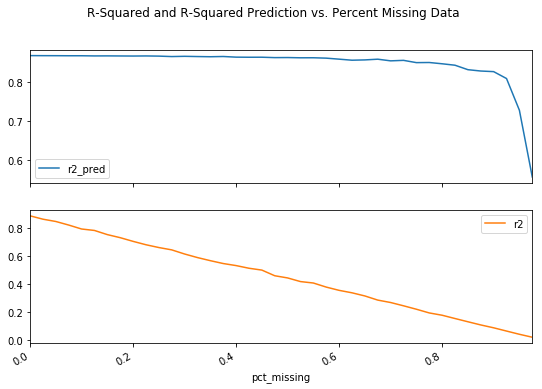

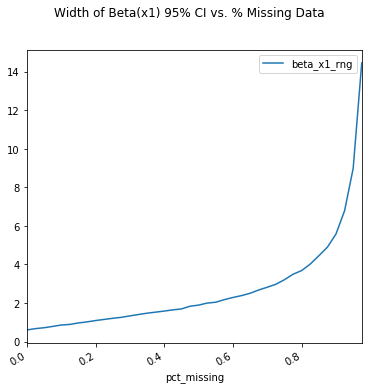

In [159]:
x1_uniform_p2_results[['r2_pred', 'r2']].plot(subplots=True, figsize=(9, 6), title='R-Squared and R-Squared Prediction vs. Percent Missing Data')
print()

x1_uniform_p2_results[['beta_x1_rng']].plot(subplots=True, figsize=(6, 6), title='Width of Beta(x1) 95% CI vs. % Missing Data')

### Case 1 - Part 2: Discussion
Okay, before diving in, let's look at what's happening in the model when we impute some data to the mean. 

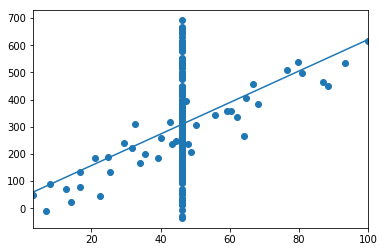

In [160]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .8, wrecked_data)

fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])

### Case 1 Comparison of Drop vs. Impute
To understand which of these two methods produces a superior model the various fit and prediction metrics are plotted side by side for each method. 


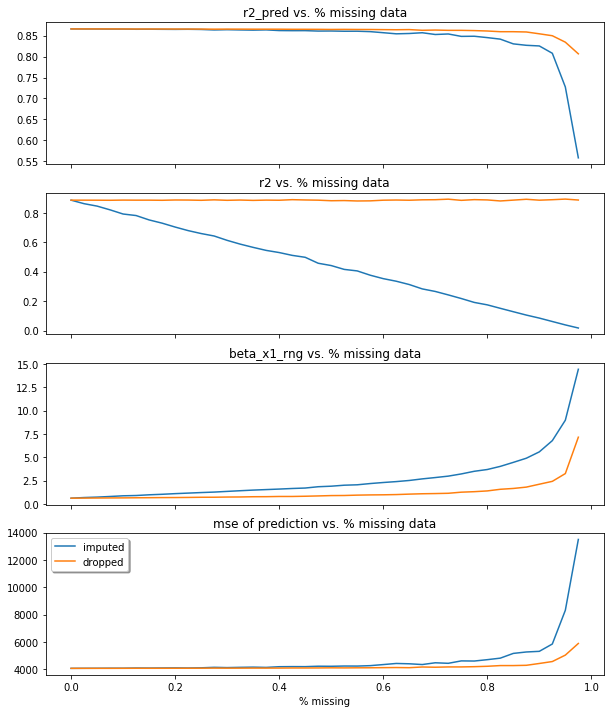

In [161]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True, figsize=(10,12))

axarr[0].plot(x1_uniform_p2_results[['r2_pred']], label='imputed')
axarr[0].plot(x1_uniform_results[['r2_pred']], label='dropped')
axarr[0].set_title('r2_pred vs. % missing data')

axarr[1].plot(x1_uniform_p2_results[['r2']], label='imputed')
axarr[1].plot(x1_uniform_results[['r2']], label='dropped')
axarr[1].set_title('r2 vs. % missing data')

axarr[2].plot(x1_uniform_p2_results[['beta_x1_rng']], label='imputed')
axarr[2].plot(x1_uniform_results[['beta_x1_rng']], label='dropped')
axarr[2].set_title('beta_x1_rng vs. % missing data')

axarr[3].plot(x1_uniform_p2_results[['mse']], label='imputed')
axarr[3].plot(x1_uniform_results[['mse']], label='dropped')
axarr[3].set_title('mse of prediction vs. % missing data')


axarr[3].set_xlabel('% missing')
plt.legend(shadow=True, fancybox=True)